# Using tf-idf to vecotrize math lectures.
#### This is the second notebookin the math lecture series. This notebook consists of feature generation using tf-idf and modeling using supervised methods.
    -To begin, we clean the data as we did in the first notebook.
    -Next, we use the tf-idf vectorizer to vectorize the lectures
    -Next, we model the tf-idf vectors as X and subject as Y (outcome)
    -Search for optimal parameter settings for tf-idf
    -In an attempt to amerilorate the accuracy further, we break down the lectures to Parts of Speach
    -Model the data using only POS
    -Combine the tf-idf vectors and POS


In [2]:
import os
import time
from collections import Counter, OrderedDict
from itertools import islice
import smart_open

import numpy as np
import pandas as pd
import scipy
import spacy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import xml.etree.ElementTree as ET  

import re
import nltk
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import cluster, ensemble, linear_model, naive_bayes, neighbors, svm
from sklearn.model_selection import cross_val_score, train_test_split, ShuffleSplit


from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, minmax_scale

from sklearn.metrics import classification_report, confusion_matrix, roc_curve,auc, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


import warnings
warnings.filterwarnings(
    module='gensim',
    action='ignore',
    message='Conversion')
warnings.filterwarnings(
    module='scipy',
    action='ignore',
    message='Using a')
warnings.filterwarnings("ignore",category=DeprecationWarning)


default_stopwords = set(nltk.corpus.stopwords.words('english'))
stemmer = nltk.stem.snowball.SnowballStemmer('english')
sns.set(style='dark',context='paper',palette='BrBG_r')
%matplotlib inline


 
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

### Importing and cleaning the data

In [4]:
#set path to XML files
path = '/root/Desktop/gits/unit-4-NLP-capstone/lectures'
folder = os.fsencode(path)

#get list of the filenames
filenames = sorted([re.sub('.xml','',os.fsdecode(file)) for file in os.listdir(folder)])


#Use ElementTree trace xml tree and extract text from xml files, removing tags
lecture_texts = []
for file in filenames:
    tree = ET.parse('lectures/{}.xml'.format(file))
    root = tree.getroot()
    all_text = []
    for elem in root:  
        for subelem in elem:
            all_text.append(subelem.text)
    lecture_texts.append(all_text)

In [5]:
raw_data = pd.DataFrame()
raw_data['filename'] = filenames
raw_data['raw_text'] = [ ' '.join(i) for i in lecture_texts ] #unpack list of lists as string
print(type(raw_data.raw_text[0]))
raw_data.head(1)

<class 'str'>


,filename,raw_text
0,aurouxmcalc1,So let's start right away with\nstuff that we ...


In [6]:
#Function to remove identified words through visual inspection
def text_cleaner(text):
    text = re.sub(r'--',', ',text) # unrecognized punctuation
    text = re.sub("[\[].*?[\]]", "", text) #remove in [audible],[laughter] etc
    text = ' '.join(text.split()) #for one long string
    #remove intros,professor names
    text = re.sub("The following content is provided under a Creative Commons license. ",'',text)
    text = re.sub('Your support will help MIT OpenCourseWare continue to',' ',text)
    text = re.sub(' offer high quality educational resources for free.',' ',text)
    text = re.sub('To make a donation or ',' ',text)
    text = re.sub('view additional materials from hundreds of MIT',' ',text)   
    text = re.sub(' courses, visit MIT OpenCourseWare at ocw.mit.edu.',' ',text)   
    text = re.sub('Haynes Miller','PROFESSOR',text)
    text = re.sub('David Jerison','PROFESSOR',text)
    text = re.sub('Srini Devadas','PROFESSOR',text)
    text = re.sub('Gilbert Strang','PROFESSOR',text)
    text = re.sub('TOM LEIGHTON','PROFESSOR',text)
    text = re.sub('PHILIPPE RIGOLLET','PROFESSOR',text)
    text = re.sub('PROFESSOR STRANG','PROFESSOR',text)
    text = re.sub('PROF. PATRICK WINSTON','PROFESSOR',text)
    text = re.sub('PROFESSOR PATRICK WINSTON','PROFESSOR',text)   
    text = re.sub('ERIK DEMAINE','PROFESSOR',text)
    text = re.sub('Demaine','PROFESSOR',text)
    text = re.sub('Erik','PROFESSOR',text)
    text = re.sub('PROF. JERISON','PROFESSOR',text)
    text = re.sub('ERIK DOMANE','PROFESSOR',text)
    text = re.sub('Erik Domane','PROFESSOR',text)
    text = re.sub('Stanford University. >>', '',text)
    text = re.sub('PATRICK WINSTON', 'PROFESSOR',text)
    text = re.sub('Welcome to 6.851 Advanced Data Structures', 'PROFESSOR',text)
    text = re.sub('PROFESSOR: PROFESSOR', ' ',text)
    text = re.sub('PROFESSOR PROFESSOR', ' ',text)
    return text

#list common contractions and full text counterpart
contractions_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "does'nt": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he has",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it would",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she had / she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "tellin": 'telling',
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "thats": "that is",
  "there'd": "there would",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "ya": "you",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had / you would",
  "you'd've": "you would have",
  "you'll": "you shall / you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"}
#function to correct the contractions
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

In [7]:
raw_data.raw_text = [ expand_contractions(i) for i in raw_data.raw_text]
raw_data.raw_text = [ text_cleaner(i) for i in raw_data.raw_text]

#label professors
raw_data['Professor'] = ['Auroux']*4 + ['Demaine']*7 + ['Devadas']*9 + ['Jerison']*9 + ['Leighton']*11 + ['Manning']*3 + ['Mattuck']*9\
+ ['Rigollet']*10 + ['Socher']*4 + ['Strang']*18 + ['Winston']* 8
#label_subjects
raw_data['Subject'] = ['Calculus']*4 + ['Data']*7 + ['Algorithms']*9 + ['Calculus']*9 + ['CS Math']*11 + ['NLP']*3\
+ ['Diff. Eq.']*9+ ['Statistics']*10 + ['NLP']*4 + ['Linear Algebra']*10 + ['Mech. Eng']* 8 +\
['AI']*8
raw_data.head(5)

,filename,raw_text,Professor,Subject
0,aurouxmcalc1,So let us start right away with stuff that we ...,Auroux,Calculus
1,aurouxmcalc11,to So far we have learned about partial...,Auroux,Calculus
2,aurouxmcalc2,"So , So, yesterday we learned about the questi...",Auroux,Calculus
3,aurouxmcalc5,"to So, so far, we have seen things abou...",Auroux,Calculus
4,demainedata1,. I am . You can call me PROFESSOR. W...,Demaine,Data


In [8]:
#Create Spacy document for each lecture
t1 = time.time()
nlp = spacy.load('en')
raw_data['sdoc'] = [nlp(i) for i in raw_data.raw_text]
print('Minutes: {}'.format((time.time()-t1)/60))

Minutes: 3.6422056754430137


In [9]:
#create a new data frame for the professor,subject and the spacy doc
sentences = raw_data[['filename','Professor','Subject','sdoc']].copy()

#create a list of lists of tokens (remove stop words and punct) 
sentences['sents'] = [ [ [token.lemma_.lower() for token in sent if not token.is_stop
        and not token.is_punct] for sent in doc.sents] for doc in sentences.sdoc]

#convert lecture lists of sentences to lecture string
sentences['text'] = [' '.join([str( ' '.join(i)) for i in j]) for j in sentences.sents]

sentences['text'] = [ ' '.join(pd.Series(sentences.text[i]).str.replace('-pron-',''))\
                     for i in range(len(sentences.text)) ]

## Initial model

In [10]:
#Split the data into train and test set.
X = np.array(sentences['text'])
y = np.array(sentences[['Professor','Subject','filename']]) #keep all labels


#As we are modeling, vectorize all of the lectures, before splitting the data

#Instantiate tf-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.50, # drop words that occur in more 50% of the sentences
                             min_df=25, # only use words that appear at least 25
                             stop_words='english', 
                             lowercase=True,
                             use_idf=True,
                             norm=u'l2',  
                             smooth_idf=True)

In [11]:
Xt = vectorizer.fit_transform(X)
tfidf_vecs = pd.DataFrame(Xt.todense())
print(tfidf_vecs.shape)
tfidf_vecs.head()

(92, 334)


,0,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
0,0.014227,0.0,0.014004,0.0,0.00000,0.011054,0.000000,0.000000,0.013378,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
1,0.000000,0.0,0.015423,0.0,0.00000,0.048699,0.000000,0.000000,0.000000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.029913,0.012989,0.0,0.0,0.000000
2,0.000000,0.0,0.000000,0.0,0.00000,0.016340,0.000000,0.000000,0.000000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.016340
3,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.00000,0.020213,0.000000,0.127391,0.0,0.000000,0.016755,0.0,0.0,0.000000
4,0.000000,0.0,0.000000,0.0,0.00785,0.015006,0.003477,0.003925,0.000000,0.00338,...,0.00798,0.000000,0.007374,0.000000,0.0,0.007374,0.003202,0.0,0.0,0.009004


In [12]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_vecs, y, test_size=.25, random_state=43)

Logistic Regression
Training Score: 0.9565217391304348


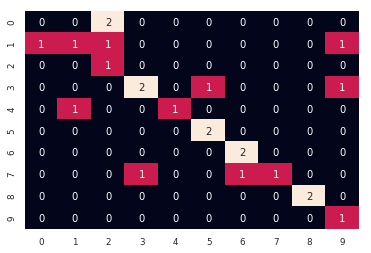

                precision    recall  f1-score   support

            AI       0.00      0.00      0.00         2
    Algorithms       0.50      0.25      0.33         4
       CS Math       0.25      1.00      0.40         1
      Calculus       0.67      0.50      0.57         4
          Data       1.00      0.50      0.67         2
     Diff. Eq.       0.67      1.00      0.80         2
Linear Algebra       0.67      1.00      0.80         2
     Mech. Eng       1.00      0.33      0.50         3
           NLP       1.00      1.00      1.00         2
    Statistics       0.33      1.00      0.50         1

     micro avg       0.57      0.57      0.57        23
     macro avg       0.61      0.66      0.56        23
  weighted avg       0.65      0.57      0.55        23

Random Forest
Training Score: 1.0


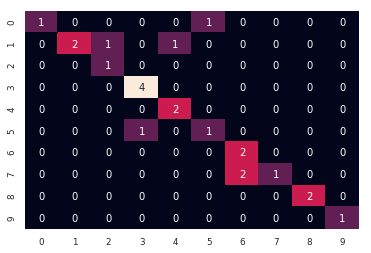

                precision    recall  f1-score   support

            AI       1.00      0.50      0.67         2
    Algorithms       1.00      0.50      0.67         4
       CS Math       0.50      1.00      0.67         1
      Calculus       0.80      1.00      0.89         4
          Data       0.67      1.00      0.80         2
     Diff. Eq.       0.50      0.50      0.50         2
Linear Algebra       0.50      1.00      0.67         2
     Mech. Eng       1.00      0.33      0.50         3
           NLP       1.00      1.00      1.00         2
    Statistics       1.00      1.00      1.00         1

     micro avg       0.74      0.74      0.74        23
     macro avg       0.80      0.78      0.74        23
  weighted avg       0.83      0.74      0.72        23

Gradient Boosting
Training Score: 1.0


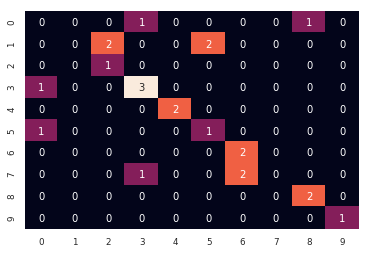

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                precision    recall  f1-score   support

            AI       0.00      0.00      0.00         2
    Algorithms       0.00      0.00      0.00         4
       CS Math       0.33      1.00      0.50         1
      Calculus       0.60      0.75      0.67         4
          Data       1.00      1.00      1.00         2
     Diff. Eq.       0.33      0.50      0.40         2
Linear Algebra       0.50      1.00      0.67         2
     Mech. Eng       0.00      0.00      0.00         3
           NLP       0.67      1.00      0.80         2
    Statistics       1.00      1.00      1.00         1

     micro avg       0.52      0.52      0.52        23
     macro avg       0.44      0.62      0.50        23
  weighted avg       0.38      0.52      0.43        23

MultinomialNB
Training Score: 0.9420289855072463


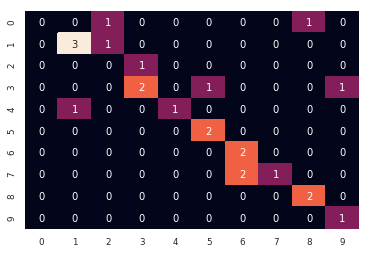

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                precision    recall  f1-score   support

            AI       0.00      0.00      0.00         2
    Algorithms       0.75      0.75      0.75         4
       CS Math       0.00      0.00      0.00         1
      Calculus       0.67      0.50      0.57         4
          Data       1.00      0.50      0.67         2
     Diff. Eq.       0.67      1.00      0.80         2
Linear Algebra       0.50      1.00      0.67         2
     Mech. Eng       1.00      0.33      0.50         3
           NLP       0.67      1.00      0.80         2
    Statistics       0.50      1.00      0.67         1

     micro avg       0.61      0.61      0.61        23
     macro avg       0.57      0.61      0.54        23
  weighted avg       0.64      0.61      0.58        23

KNegihbors
Training Score: 1.0


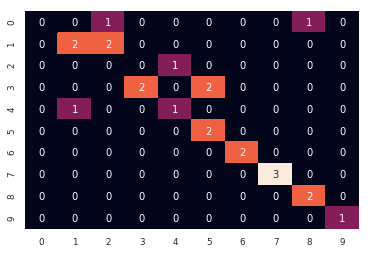

                precision    recall  f1-score   support

            AI       0.00      0.00      0.00         2
    Algorithms       0.67      0.50      0.57         4
       CS Math       0.00      0.00      0.00         1
      Calculus       1.00      0.50      0.67         4
          Data       0.50      0.50      0.50         2
     Diff. Eq.       0.50      1.00      0.67         2
Linear Algebra       1.00      1.00      1.00         2
     Mech. Eng       1.00      1.00      1.00         3
           NLP       0.67      1.00      0.80         2
    Statistics       1.00      1.00      1.00         1

     micro avg       0.65      0.65      0.65        23
     macro avg       0.63      0.65      0.62        23
  weighted avg       0.70      0.65      0.65        23



/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
print('Logistic Regression')
lrc = linear_model.LogisticRegression(C=1, solver='newton-cg', multi_class='multinomial', random_state=43)
lrc.fit(X_train,y_train[:,1])
print("Training Score: {}".format(lrc.score(X_train, y_train[:,1])))

y_pred = lrc.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))

print('Random Forest')
rfc = ensemble.RandomForestClassifier(n_estimators=200, max_depth=4, min_samples_leaf=4, random_state=43,
                                     class_weight='balanced')
rfc.fit(X_train,y_train[:,1])
print("Training Score: {}".format(rfc.score(X_train, y_train[:,1])))
y_pred = rfc.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))

print('Gradient Boosting')

gbc = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=3)
gbc.fit(X_train,y_train[:,1])
print("Training Score: {}".format(gbc.score(X_train, y_train[:,1])))
y_pred = gbc.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))

print('MultinomialNB')

bmb = naive_bayes.MultinomialNB(alpha=.3)
bmb.fit(X_train,y_train[:,1])
print("Training Score: {}".format(bmb.score(X_train, y_train[:,1])))
y_pred = bmb.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))

print('KNegihbors')

knn = neighbors.KNeighborsClassifier(n_neighbors=2, weights='distance')
knn.fit(X_train,y_train[:,1])
print("Training Score: {}".format(knn.score(X_train, y_train[:,1])))
y_pred = knn.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))

## Parameter Search

In [14]:
rfc_min = []
min_df = []
for i in np.arange(5,30,1):
    vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more 50% of the sentences
                             min_df=i, # only use words that appear at least 25
                             stop_words='english', 
                             lowercase=True,
                             use_idf=True,
                             norm=u'l2',  
                             smooth_idf=True)
    Xt = vectorizer.fit_transform(X)
    tfidf_vecs = pd.DataFrame(Xt.todense())
    X_train, X_test, y_train, y_test = train_test_split(tfidf_vecs, y, test_size=.25, random_state=43)
    rfc.fit(X_train,y_train[:,1])
    rfc_min.append(rfc.score(X_test,y_test[:,1]))
    min_df.append(i)

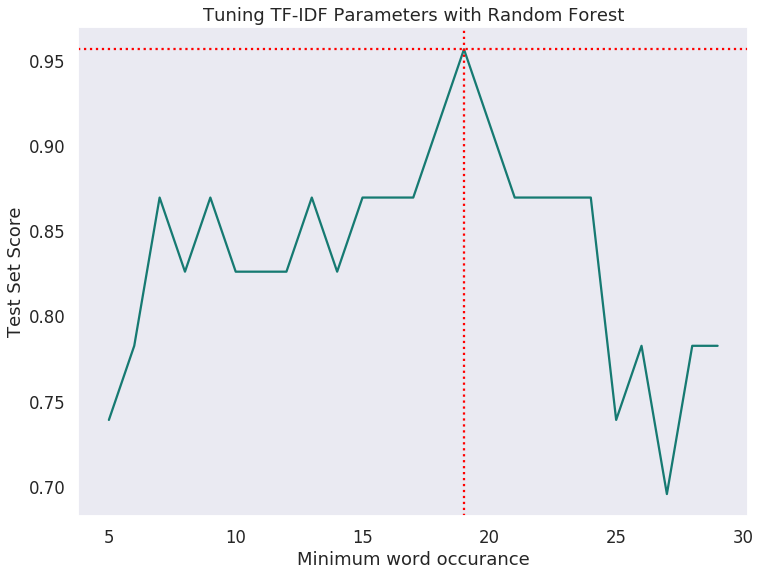

In [15]:
sns.set_context('talk')
plt.figure(figsize=(12,9))
ax = sns.lineplot(x=min_df,y=rfc_min)
ax.axvline(min_df[np.argmax(rfc_min)], c='r', linestyle='dotted')
ax.axhline(max(rfc_min), c='r', linestyle='dotted')
plt.xlabel("Minimum word occurance")
plt.ylabel('Test Set Score')
plt.title("Tuning TF-IDF Parameters with Random Forest")
plt.show()

## Extracting POS

In [16]:
#turn each sentence into its pos
posseslc = [ [ [ token.pos_ for token in sentence if not token.is_stop and not token.is_punct] for sentence in list(lecture.sents)]for lecture in sentences.sdoc ]

In [17]:
#iterate over each lecture extracting lists of POS for each sentence
def get_pos (doc_list, norm):
    #start timer, creat lists
    t1 = time.time()    
    pos_list = [] #list of all POS
    poss_list = []#list of sentences as POS
    
    #iterate over list of spacy docs
    for lecture in doc_list:    
        pss = []
        #Extract POS
        for token in lecture:
            pss.append(token.pos_)
            pos_list.append(token.pos_)
        poss_list.append(pss)

    #Set up up a DataFrame to count occurance of POS per lecture
    pos_df = pd.DataFrame(columns=set(pos_list))
    pos_df['pos_sent'] = poss_list
    pos_df.loc[:, pos_list] = 0

    for i, sentence in enumerate(pos_df['pos_sent']):
        
            # Convert the sentence words to POS
            words = pos_df.pos_sent[i]

            # Populate the row with word counts.
            for word in words:
                pos_df.loc[i, word] += 1
                
        # get total pos count in the lecture
    pos_df['length'] = pos_df.drop(['pos_sent'],1).sum(axis=1)
    
    if norm == True:
        #if True, divids POS count by length (total POS count)
        for col in pos_df.drop(['pos_sent','length'],1).columns:
                    pos_df[col] = pos_df[col]/pos_df.length
        
        
    pos_df.drop(['pos_sent'],1,inplace=True)
    
    print("time: {} minutes".format((time.time()-t1)/60))
    return pos_df

In [18]:
pos_count = get_pos(sentences.sdoc, True)

time: 5.460794333616892 minutes


In [19]:
pos_count.to_csv('pos_count.csv')

In [20]:
X.shape

(92,)

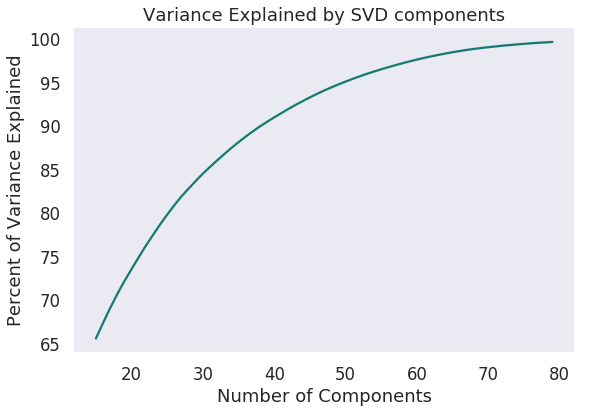

In [21]:
#Here we explore the possibility of  reducing the dimensionality for run time
exp_var = []
comps = []
tot_var = []
for i in range(15,80):
    svd = TruncatedSVD(n_components=i)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    temp_vecs = lsa.fit(tfidf_vecs)
    exp_var.append(svd.explained_variance_ratio_.sum()*100)
    comps.append(i)
    
plt.figure(figsize=(9,6))
sns.lineplot(x=comps, y=exp_var)
plt.xlabel('Number of Components')
plt.ylabel('Percent of Variance Explained')
plt.title('Variance Explained by SVD components')
plt.show()
    

## Using POS counts only

In [22]:
#use POS function, without normalizing
pos_false = get_pos(sentences.sdoc, False)

time: 5.3764045635859175 minutes


In [23]:
X_train, X_test, y_train, y_test = train_test_split(pos_false, y, test_size=.25, random_state=43)

Logistic Regression
Training Score: 1.0


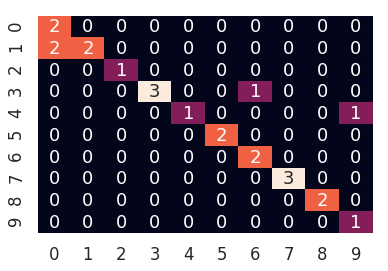

                precision    recall  f1-score   support

            AI       0.50      1.00      0.67         2
    Algorithms       1.00      0.50      0.67         4
       CS Math       1.00      1.00      1.00         1
      Calculus       1.00      0.75      0.86         4
          Data       1.00      0.50      0.67         2
     Diff. Eq.       1.00      1.00      1.00         2
Linear Algebra       0.67      1.00      0.80         2
     Mech. Eng       1.00      1.00      1.00         3
           NLP       1.00      1.00      1.00         2
    Statistics       0.50      1.00      0.67         1

     micro avg       0.83      0.83      0.83        23
     macro avg       0.87      0.88      0.83        23
  weighted avg       0.91      0.83      0.83        23

Random Forest
Training Score: 0.9710144927536232


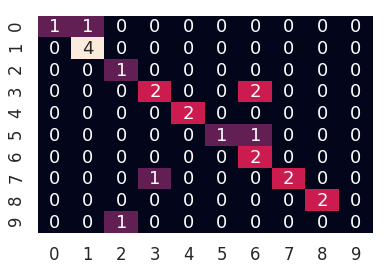

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                precision    recall  f1-score   support

            AI       1.00      0.50      0.67         2
    Algorithms       0.80      1.00      0.89         4
       CS Math       0.50      1.00      0.67         1
      Calculus       0.67      0.50      0.57         4
          Data       1.00      1.00      1.00         2
     Diff. Eq.       1.00      0.50      0.67         2
Linear Algebra       0.40      1.00      0.57         2
     Mech. Eng       1.00      0.67      0.80         3
           NLP       1.00      1.00      1.00         2
    Statistics       0.00      0.00      0.00         1

     micro avg       0.74      0.74      0.74        23
     macro avg       0.74      0.72      0.68        23
  weighted avg       0.79      0.74      0.73        23

Gradient Boosting
Training Score: 1.0


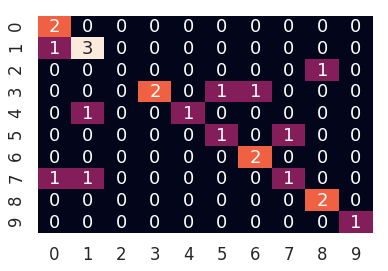

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                precision    recall  f1-score   support

            AI       0.50      1.00      0.67         2
    Algorithms       0.60      0.75      0.67         4
       CS Math       0.00      0.00      0.00         1
      Calculus       1.00      0.50      0.67         4
          Data       1.00      0.50      0.67         2
     Diff. Eq.       0.50      0.50      0.50         2
Linear Algebra       0.67      1.00      0.80         2
     Mech. Eng       0.50      0.33      0.40         3
           NLP       0.67      1.00      0.80         2
    Statistics       1.00      1.00      1.00         1

     micro avg       0.65      0.65      0.65        23
     macro avg       0.64      0.66      0.62        23
  weighted avg       0.68      0.65      0.63        23

MultinomialNB
KNegihbors
Training Score: 1.0


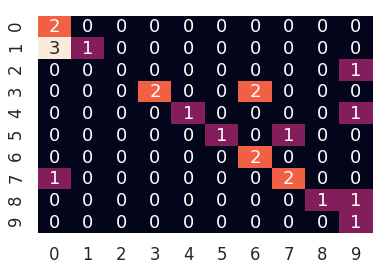

                precision    recall  f1-score   support

            AI       0.33      1.00      0.50         2
    Algorithms       1.00      0.25      0.40         4
       CS Math       0.00      0.00      0.00         1
      Calculus       1.00      0.50      0.67         4
          Data       1.00      0.50      0.67         2
     Diff. Eq.       1.00      0.50      0.67         2
Linear Algebra       0.50      1.00      0.67         2
     Mech. Eng       0.67      0.67      0.67         3
           NLP       1.00      0.50      0.67         2
    Statistics       0.25      1.00      0.40         1

     micro avg       0.57      0.57      0.57        23
     macro avg       0.68      0.59      0.53        23
  weighted avg       0.78      0.57      0.57        23



/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
print('Logistic Regression')
lrc = linear_model.LogisticRegression(C=1, solver='newton-cg', multi_class='multinomial', random_state=43,  max_iter=1000)
lrc.fit(X_train,y_train[:,1])
print("Training Score: {}".format(lrc.score(X_train, y_train[:,1])))

y_pred = lrc.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))

print('Random Forest')
rfc = ensemble.RandomForestClassifier(n_estimators=200, max_depth=4, min_samples_leaf=4, random_state=43,
                                     class_weight='balanced')
rfc.fit(X_train,y_train[:,1])
print("Training Score: {}".format(rfc.score(X_train, y_train[:,1])))
y_pred = rfc.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))

print('Gradient Boosting')

gbc = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=3)
gbc.fit(X_train,y_train[:,1])
print("Training Score: {}".format(gbc.score(X_train, y_train[:,1])))
y_pred = gbc.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))

print('MultinomialNB')

'''bmb = naive_bayes.MultinomialNB(alpha=.3)
bmb.fit(X_train,y_train[:,1])
print("Training Score: {}".format(bmb.score(X_train, y_train[:,1])))
y_pred = bmb.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))'''

print('KNegihbors')

knn = neighbors.KNeighborsClassifier(n_neighbors=2, weights='distance')
knn.fit(X_train,y_train[:,1])
print("Training Score: {}".format(knn.score(X_train, y_train[:,1])))
y_pred = knn.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))

In [25]:
new_X = pd.concat([tfidf_vecs,pos_count],axis=1)
new_X.head()

,0,1,2,3,4,5,6,7,8,9,...,CCONJ,NUM,ADJ,NOUN,SPACE,PRON,VERB,PROPN,PART,length
0,0.0,0.017590,0.013885,0.00000,0.016803,0.000000,0.000000,0.000000,0.000000,0.016557,...,0.0310872,0.023793,0.0508857,0.154741,0,0.0811046,0.167419,0.0109413,0.0180618,5758.0
1,0.0,0.026686,0.084259,0.00000,0.000000,0.000000,0.000000,0.022473,0.000000,0.000000,...,0.040658,0.00791434,0.0628492,0.166201,0.000310366,0.0889199,0.177529,0.00574178,0.0234327,6444.0
2,0.0,0.000000,0.017214,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020526,...,0.0305839,0.0261044,0.0478838,0.145351,0,0.0735249,0.175935,0.0114303,0.0160643,6474.0
3,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.018405,0.018652,0.020571,...,0.0359928,0.0190462,0.0484403,0.134673,0.00029994,0.089832,0.171416,0.00419916,0.0173965,6668.0
4,0.0,0.000000,0.019726,0.00457,0.000000,0.004444,0.008094,0.008418,0.000000,0.000000,...,0.0323816,0.0097493,0.0744429,0.160167,0.000139276,0.0783426,0.192827,0.00473538,0.0224234,14360.0


In [26]:


X_train, X_test, y_train, y_test = train_test_split(pos_count, y, test_size=.25, random_state=43)

Logistic Regression


/root/.pyenv/versions/jupyter3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/root/.pyenv/versions/jupyter3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Training Score: 0.4927536231884058


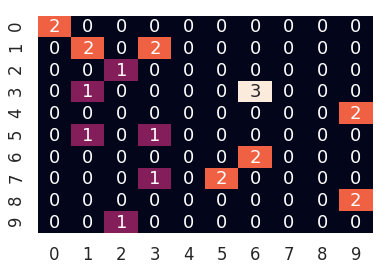

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                precision    recall  f1-score   support

            AI       1.00      1.00      1.00         2
    Algorithms       0.50      0.50      0.50         4
       CS Math       0.50      1.00      0.67         1
      Calculus       0.00      0.00      0.00         4
          Data       0.00      0.00      0.00         2
     Diff. Eq.       0.00      0.00      0.00         2
Linear Algebra       0.40      1.00      0.57         2
     Mech. Eng       0.00      0.00      0.00         3
           NLP       0.00      0.00      0.00         2
    Statistics       0.00      0.00      0.00         1

     micro avg       0.30      0.30      0.30        23
     macro avg       0.24      0.35      0.27        23
  weighted avg       0.23      0.30      0.25        23

Random Forest
Training Score: 1.0


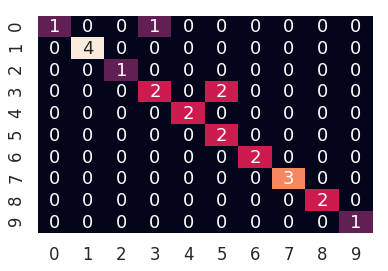

                precision    recall  f1-score   support

            AI       1.00      0.50      0.67         2
    Algorithms       1.00      1.00      1.00         4
       CS Math       1.00      1.00      1.00         1
      Calculus       0.67      0.50      0.57         4
          Data       1.00      1.00      1.00         2
     Diff. Eq.       0.50      1.00      0.67         2
Linear Algebra       1.00      1.00      1.00         2
     Mech. Eng       1.00      1.00      1.00         3
           NLP       1.00      1.00      1.00         2
    Statistics       1.00      1.00      1.00         1

     micro avg       0.87      0.87      0.87        23
     macro avg       0.92      0.90      0.89        23
  weighted avg       0.90      0.87      0.87        23

Gradient Boosting
Training Score: 1.0


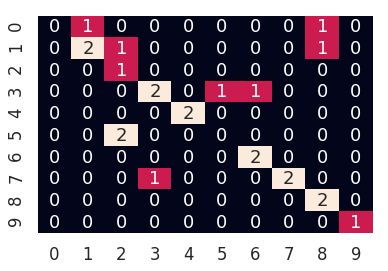

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                precision    recall  f1-score   support

            AI       0.00      0.00      0.00         2
    Algorithms       0.67      0.50      0.57         4
       CS Math       0.25      1.00      0.40         1
      Calculus       0.67      0.50      0.57         4
          Data       1.00      1.00      1.00         2
     Diff. Eq.       0.00      0.00      0.00         2
Linear Algebra       0.67      1.00      0.80         2
     Mech. Eng       1.00      0.67      0.80         3
           NLP       0.50      1.00      0.67         2
    Statistics       1.00      1.00      1.00         1

     micro avg       0.61      0.61      0.61        23
     macro avg       0.57      0.67      0.58        23
  weighted avg       0.61      0.61      0.58        23

MultinomialNB
KNegihbors
Training Score: 1.0


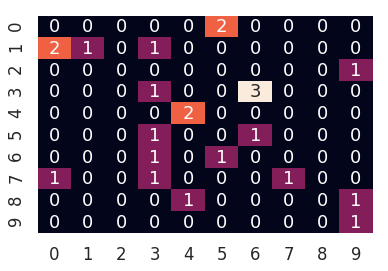

                precision    recall  f1-score   support

            AI       0.00      0.00      0.00         2
    Algorithms       1.00      0.25      0.40         4
       CS Math       0.00      0.00      0.00         1
      Calculus       0.20      0.25      0.22         4
          Data       0.67      1.00      0.80         2
     Diff. Eq.       0.00      0.00      0.00         2
Linear Algebra       0.00      0.00      0.00         2
     Mech. Eng       1.00      0.33      0.50         3
           NLP       0.00      0.00      0.00         2
    Statistics       0.33      1.00      0.50         1

     micro avg       0.26      0.26      0.26        23
     macro avg       0.32      0.28      0.24        23
  weighted avg       0.41      0.26      0.26        23



/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
print('Logistic Regression')
lrc = linear_model.LogisticRegression(C=1, solver='newton-cg', multi_class='multinomial', random_state=43,  max_iter=10000)
lrc.fit(X_train,y_train[:,1])
print("Training Score: {}".format(lrc.score(X_train, y_train[:,1])))

y_pred = lrc.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))

print('Random Forest')
rfc = ensemble.RandomForestClassifier(n_estimators=200, max_depth=4, min_samples_leaf=4, random_state=43,
                                     class_weight='balanced')
rfc.fit(X_train,y_train[:,1])
print("Training Score: {}".format(rfc.score(X_train, y_train[:,1])))
y_pred = rfc.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))

print('Gradient Boosting')

gbc = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=3)
gbc.fit(X_train,y_train[:,1])
print("Training Score: {}".format(gbc.score(X_train, y_train[:,1])))
y_pred = gbc.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))

print('MultinomialNB')

'''bmb = naive_bayes.MultinomialNB(alpha=.3)
bmb.fit(X_train,y_train[:,1])
print("Training Score: {}".format(bmb.score(X_train, y_train[:,1])))
y_pred = bmb.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))'''

print('KNegihbors')

knn = neighbors.KNeighborsClassifier(n_neighbors=2, weights='distance')
knn.fit(X_train,y_train[:,1])
print("Training Score: {}".format(knn.score(X_train, y_train[:,1])))
y_pred = knn.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))

In [28]:
#Instantiate tf-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.50, # drop words that occur in more 50% of the sentences
                             min_df=25, # only use words that appear at least 25
                             stop_words='english', 
                             lowercase=True,
                             use_idf=True,
                             norm=u'l2',  
                             smooth_idf=True)
#Convert to dense arrays
Xt = vectorizer.fit_transform(X)
tfidf_vecs = pd.DataFrame(Xt.todense())

tfidf_vecs.shape

(92, 334)

In [29]:
Xt = vectorizer.fit_transform(X)
tfidf_vecs = pd.DataFrame(Xt.todense())

In [30]:
pos_count.shape

(92, 17)

In [31]:
model_vecs = pd.concat( [ tfidf_vecs, pos_count ],axis=1)
model_vecs.shape

(92, 351)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(model_vecs, y, test_size=.25, random_state=43)

Logistic Regression


/root/.pyenv/versions/jupyter3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/root/.pyenv/versions/jupyter3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


Training Score: 0.927536231884058


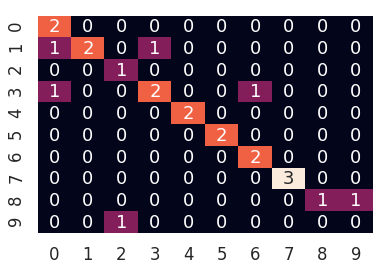

                precision    recall  f1-score   support

            AI       0.50      1.00      0.67         2
    Algorithms       1.00      0.50      0.67         4
       CS Math       0.50      1.00      0.67         1
      Calculus       0.67      0.50      0.57         4
          Data       1.00      1.00      1.00         2
     Diff. Eq.       1.00      1.00      1.00         2
Linear Algebra       0.67      1.00      0.80         2
     Mech. Eng       1.00      1.00      1.00         3
           NLP       1.00      0.50      0.67         2
    Statistics       0.00      0.00      0.00         1

     micro avg       0.74      0.74      0.74        23
     macro avg       0.73      0.75      0.70        23
  weighted avg       0.80      0.74      0.73        23

Random Forest
Training Score: 1.0


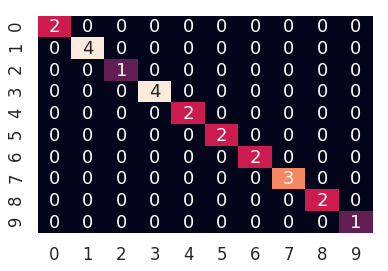

                precision    recall  f1-score   support

            AI       1.00      1.00      1.00         2
    Algorithms       1.00      1.00      1.00         4
       CS Math       1.00      1.00      1.00         1
      Calculus       1.00      1.00      1.00         4
          Data       1.00      1.00      1.00         2
     Diff. Eq.       1.00      1.00      1.00         2
Linear Algebra       1.00      1.00      1.00         2
     Mech. Eng       1.00      1.00      1.00         3
           NLP       1.00      1.00      1.00         2
    Statistics       1.00      1.00      1.00         1

     micro avg       1.00      1.00      1.00        23
     macro avg       1.00      1.00      1.00        23
  weighted avg       1.00      1.00      1.00        23

Gradient Boosting
Training Score: 1.0


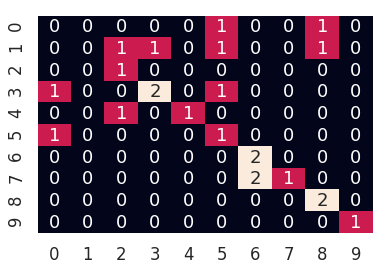

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                precision    recall  f1-score   support

            AI       0.00      0.00      0.00         2
    Algorithms       0.00      0.00      0.00         4
       CS Math       0.33      1.00      0.50         1
      Calculus       0.67      0.50      0.57         4
          Data       1.00      0.50      0.67         2
     Diff. Eq.       0.25      0.50      0.33         2
Linear Algebra       0.50      1.00      0.67         2
     Mech. Eng       1.00      0.33      0.50         3
           NLP       0.50      1.00      0.67         2
    Statistics       1.00      1.00      1.00         1

     micro avg       0.48      0.48      0.48        23
     macro avg       0.53      0.58      0.49        23
  weighted avg       0.50      0.48      0.43        23

MultinomialNB
Training Score: 0.2753623188405797


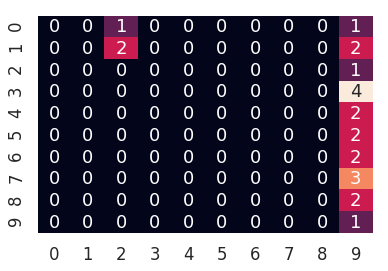

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                precision    recall  f1-score   support

            AI       0.00      0.00      0.00         2
    Algorithms       0.00      0.00      0.00         4
       CS Math       0.00      0.00      0.00         1
      Calculus       0.00      0.00      0.00         4
          Data       0.00      0.00      0.00         2
     Diff. Eq.       0.00      0.00      0.00         2
Linear Algebra       0.00      0.00      0.00         2
     Mech. Eng       0.00      0.00      0.00         3
           NLP       0.00      0.00      0.00         2
    Statistics       0.05      1.00      0.10         1

     micro avg       0.04      0.04      0.04        23
     macro avg       0.01      0.10      0.01        23
  weighted avg       0.00      0.04      0.00        23

KNegihbors
Training Score: 1.0


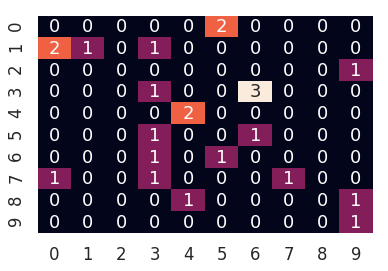

                precision    recall  f1-score   support

            AI       0.00      0.00      0.00         2
    Algorithms       1.00      0.25      0.40         4
       CS Math       0.00      0.00      0.00         1
      Calculus       0.20      0.25      0.22         4
          Data       0.67      1.00      0.80         2
     Diff. Eq.       0.00      0.00      0.00         2
Linear Algebra       0.00      0.00      0.00         2
     Mech. Eng       1.00      0.33      0.50         3
           NLP       0.00      0.00      0.00         2
    Statistics       0.33      1.00      0.50         1

     micro avg       0.26      0.26      0.26        23
     macro avg       0.32      0.28      0.24        23
  weighted avg       0.41      0.26      0.26        23



/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
print('Logistic Regression')
lrc = linear_model.LogisticRegression(C=1, solver='newton-cg', multi_class='multinomial', random_state=43)
lrc.fit(X_train,y_train[:,1])
print("Training Score: {}".format(lrc.score(X_train, y_train[:,1])))

y_pred = lrc.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))

print('Random Forest')
rfc = ensemble.RandomForestClassifier(n_estimators=200, max_depth=4, min_samples_leaf=4, random_state=43,
                                     class_weight='balanced')
rfc.fit(X_train,y_train[:,1])
print("Training Score: {}".format(rfc.score(X_train, y_train[:,1])))
y_pred = rfc.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))

print('Gradient Boosting')

gbc = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=3)
gbc.fit(X_train,y_train[:,1])
print("Training Score: {}".format(gbc.score(X_train, y_train[:,1])))
y_pred = gbc.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))

print('MultinomialNB')

bmb = naive_bayes.MultinomialNB(alpha=.3)
bmb.fit(X_train,y_train[:,1])
print("Training Score: {}".format(bmb.score(X_train, y_train[:,1])))
y_pred = bmb.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))

print('KNegihbors')

knn = neighbors.KNeighborsClassifier(n_neighbors=2, weights='distance')
knn.fit(X_train,y_train[:,1])
print("Training Score: {}".format(knn.score(X_train, y_train[:,1])))
y_pred = knn.predict(X_test)
sns.heatmap(confusion_matrix(y_test[:,1], y_pred), annot=True, fmt='d',cbar=False)
plt.show()
print(classification_report(y_test[:,1],y_pred))

In [34]:
[round(i,2) for i in cross_val_score(rfc,tfidf_vecs, y[:,1],cv=5)]

[0.95, 0.86, 0.95, 0.94, 0.93]

In [35]:
round(np.array([round(i,2) for i in cross_val_score(rfc,tfidf_vecs, y[:,1],cv=5)]).mean(),2)

0.93